# Project: Artificial Financial Advisor on Peer-to-Peer lending -- Part 1

--by Lu Tang

## Introduction

LendingClub is the first and largest online peer-to-peer ('P2P') platform to facilitate lending and borrowing of unsecured loans. As explained by Wikipedia:

- Lending Club enables borrowers to create unsecured personal loans between $1,000  and  $40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

**The goal of this project**: Build a machine learning model that can help investor reduce the investment risk by building a portfolio with selected loans.

**Data Source** : Personal loan payment dataset from LendingClub Corp, LC, available on [LendingClub Statistics](https://www.lendingclub.com/info/download-data.action)

The dataset I am working on is from 2007 to 2019 quarter 2; In total, there are about 2.5 millions of loans in this data. Each row is one loan, and it covers an extensive amount of information on the borrower's side that was originally available to lenders when they made investment choices. 

**Note**: I used the all the data available including the recent loan data for two reasons:

1. I want to analyze all the loan data to find insight about default rate and year trends.
2. After researching, I found that for the loans that are issued in recent years, although the loan term is either 36 months or 60 months, there are many loans that are pre-paid or charged off before it is expired. Those are still the data that I can use in the model. 

The whole projects are separated in two parts, and this is part 2. 

- Part 1 Understanding and Cleaning data, Identifying investment problem

- Part 2 Choosing the best model for investors

## Part 1 Understanding and Cleaning data, Identifying investment problem

## Table of Contents
<ul>
<li><a href="#data">1. Understanding and Visualizing data</a></li> 
<li><a href="#clean">2. Cleaning Data</a></li>
<li><a href="#category">3. More Data Cleaning on Category columns</a></li>
<li><a href="#missing">4. Handling missing values</a></li>
<li><a href="#summary">5. Summary</a></li>
</ul> 

**Import Python libraries and make general settings:**

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to make better chart
sns.set_style('whitegrid')
plt.figure(figsize = (10,6))
sns.despine(left=True, bottom=True)

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

<Figure size 720x432 with 0 Axes>

<a id='data'></a>
## 1. Understanding and Visualizing data

Before we load data, let's view the data dictionary, this can be found at the bottom of [Lending loop statistic website](https://www.lendingclub.com/info/download-data.action)

**1.1 View the data dictionary**

In [3]:
# load data dictionary
data_dic = pd.read_excel('LCDataDictionary.xlsx')

# view how many columns it descripes
print('The number of rows in the data dictionary is: ', data_dic.shape[0])

# view first 5 rows
data_dic.head()

The number of rows in the data dictionary is:  153


,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


There are 152 column description. To save space, I didn't show all the description, Click [here](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit#gid=2081333097) to view what does each column mean.

We don't have to dig deep for every column for now, but we will need to review it after a few cleaning.

After researching the data dictionary, I decided that **`loan_status` is my target column**, since it's the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. 

There are 8 different possible values for the `loan_status` column. We can read about most of the different loan status on the [Lending Club webste](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-). The two values that start with "Does not meet the credit policy" aren't explained unfortunately. A quick Google search takes us to explanations from the lending community [here](https://forum.lendacademy.com/?topic=2427.msg20813#msg20813).

**1.2 Loading data files from different years**

I have downloaded all the data available from [Lending Club Statistic](https://www.lendingclub.com/info/download-data.action). By the time of this project, I have data from 2007 to 2019 Q2; However the datastes are in different files, let's first load all of them and view the first rows and check the shape of the dataset. 

**Let's first read the oldest data file, i.e. loan informations from 2007 to 2011**

In [4]:
# load the data from 2007-2011
# the first row (row number 0) is only one column, which contains Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
# the second row is actually the columns name, that is wht header=1
loans_07_11=pd.read_csv('LoanStats3a.csv', header=1) 

# view first row
display(loans_07_11.head(1))

# check the row and columns number
print('The number of rows and columns is: ', loans_07_11.shape)

print('The value of loan status in this dataset is: ')
# view the loan status in this dataset
loans_07_11['loan_status'].value_counts()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.0,0.0,0.0,Jan-2015,171.62,NaN,May-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


The number of rows and columns is:  (42538, 144)
The value of loan status in this dataset is: 


Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

- As expected, since all the loans in this year range are expired, no current loans.
- The data is not in a format that can be used to analyze or machine learning, we will clean it later.

**Now let's read the most recent data file, i.e. loan informations for 2009 Quarter 2**

In [5]:
# load the data from 2009 quarter 2
loans_2019_q2=pd.read_csv('LoanStats_2019Q2.csv',header=1)

# view first row
display(loans_2019_q2.head(1))

# check the row and columns number
print('The number of rows and columns is: ',loans_2019_q2.shape)

# view the loan status in this dataset
print('The value of loan status in this dataset is: ')
loans_2019_q2['loan_status'].value_counts()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,32000.0,32000.0,32000.0,60 months,16.95%,794.43,C,C4,Crane Operator,10+ years,MORTGAGE,90000.0,Not Verified,Jun-2019,Issued,n,NaN,NaN,debt_consolidation,Debt consolidation,604xx,IL,34.01,0.0,Jan-1997,0.0,NaN,NaN,6.0,0.0,66227.0,93.3%,11.0,w,32000.0,32000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jul-2019,Jul-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,153731.0,0.0,1.0,0.0,0.0,38.0,35008.0,NaN,0.0,0.0,29475.0,93.0,71000.0,0.0,0.0,0.0,0.0,25622.0,4773.0,93.3,0.0,0.0,131.0,269.0,69.0,38.0,1.0,69.0,NaN,NaN,NaN,0.0,4.0,4.0,4.0,5.0,4.0,4.0,6.0,4.0,6.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,217834.0,101235.0,71000.0,69034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


The number of rows and columns is:  (131141, 144)
The value of loan status in this dataset is: 


Current               119074
Issued                  8713
Fully Paid              2502
In Grace Period          427
Late (31-120 days)       221
Late (16-30 days)        180
Charged Off               22
Name: loan_status, dtype: int64

- Since all the loans this data file are from 2019 Quarter 2, most loans have status as **Current**, which means the loan is up to date on all outstanding payments and we don't know whether they will be paid off or charged off. Some loans are **Fully Paid**, it is more likely that they are **pre-paid**. Again, We can read about most of the different loan statuses on the [Lending Club webste](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-).  

Next step we will continue load all the other dataset and then combine them all together. (To save space, I will not show all other dataset one by one; I have viewed all of them and found that they all have the same number of columns and same column names, so all the dataset can be combined together using pd.concat)

In [6]:
# load the data for 2012 and 2013
loans_12_13=pd.read_csv('LoanStats3b.csv', header=1)

# load the data for 2014
loans_2014=pd.read_csv('LoanStats3c.csv', header=1)

# load the data for 2015
loans_2015=pd.read_csv('LoanStats3d.csv',header=1)

# load the data for 2016 Quarter 1
loans_2016_q1=pd.read_csv('LoanStats_2016Q1.csv',header=1)

# load the data for 2016 Quarter 2
loans_2016_q2=pd.read_csv('LoanStats_2016Q2.csv',header=1)

# load the data for 2016 Quarter 3
loans_2016_q3=pd.read_csv('LoanStats_2016Q3.csv',header=1)

# load the data for 2016 Quarter 4
loans_2016_q4=pd.read_csv('LoanStats_2016Q4.csv',header=1)

# load the data for 2017 Quarter 1
loans_2017_q1=pd.read_csv('LoanStats_2017Q1.csv',header=1)

# load the data for 2017 Quarter 2
loans_2017_q2=pd.read_csv('LoanStats_2017Q2.csv',header=1)

# load the data for 2017 Quarter 3
loans_2017_q3=pd.read_csv('LoanStats_2017Q3.csv',header=1)

# load the data for 2017 Quarter 4
loans_2017_q4=pd.read_csv('LoanStats_2017Q4.csv',header=1)

# load the data for 2018 Quarter 1
loans_2018_q1=pd.read_csv('LoanStats_2018Q1.csv',header=1)

# load the data for 2018 Quarter 2
loans_2018_q2=pd.read_csv('LoanStats_2018Q2.csv',header=1)

# load the data for 2018 Quarter 3
loans_2018_q3=pd.read_csv('LoanStats_2018Q3.csv',header=1)

# load the data for 2018 Quarter 4
loans_2018_q4=pd.read_csv('LoanStats_2018Q4.csv',header=1)

# load the data for 2019 Quarter 1
loans_2019_q1=pd.read_csv('LoanStats_2019Q1.csv',header=1)

# load the data for 2019 Quarter 2
loans_2019_q2=pd.read_csv('LoanStats_2019Q2.csv',header=1)

**1.3 Combining all the data files from different years into one files.**

In [7]:
# combine the files together
loans_2007_2019 = pd.concat([loans_07_11, loans_12_13, loans_2014, loans_2015, loans_2016_q1, loans_2016_q2,
                        loans_2016_q3, loans_2016_q4, loans_2017_q1, loans_2017_q2, loans_2017_q3, loans_2017_q4,
                        loans_2018_q1, loans_2018_q2, loans_2018_q3, loans_2018_q4, loans_2019_q1, loans_2019_q2])
print('The number of rows and columns is: ', loans_2007_2019.shape)

The number of rows and columns is:  (2507519, 144)


Great! Now we have a massive dataset that contains roughly 2.5 millions loans information. 

**Aggregate and plot our data**

I decided to do this before cleaning because cleaning will remove some rows and made our plot less accurate. 

**1.4 Visualize the number of loans with the status of fully paid and charged off**

Since we're interested in being able to predict which of these 2 values a loan will fall under, we can treat the problem as a binary classification one. We will need to remove all the loans that don't contain either Fully Paid and Charged Off as the loan's status. 

In [8]:
# Remove all rows that contain values other than Fully Paid or Charged Off for the loan_status column
loans_paid_or_default = loans_2007_2019.loc[loans_2007_2019['loan_status'].isin(['Fully Paid', 'Charged Off'])]

Text(0, 0.5, 'The number of loans for each status')

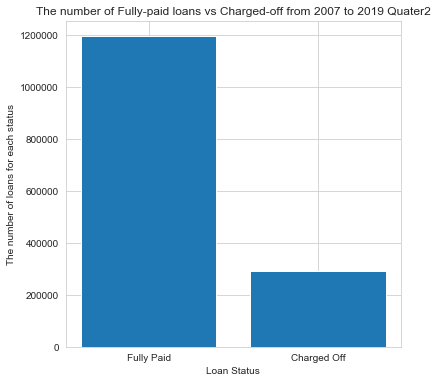

In [9]:
# code for plotting bar chart for loan status:
plt.figure(figsize=(6,6))
plt.bar(loans_paid_or_default['loan_status'].value_counts().index, loans_paid_or_default['loan_status'].value_counts().values)
plt.title('The number of Fully-paid loans vs Charged-off from 2007 to 2019 Quater2')
plt.xlabel('Loan Status')
plt.ylabel('The number of loans for each status')

In [11]:
loans_paid_or_default['loan_status'].value_counts()

Fully Paid     1194845
Charged Off     290679
Name: loan_status, dtype: int64

In [12]:
charged_off_rate = 290679/(290679+1194845)

print('The charged off rate for all the loans from 2007 to 2019 is: ', charged_off_rate)

The charged off rate for all the loans from 2007 to 2019 is:  0.19567438829665493


**Analyze**
- Based on these data, the Charged Off rate for all the loans in average is **19.57%**. This means if we choose loans to invest randomly, we could have about 19% of charged off rate. This is very **high risk**.
- Charged off rate is similar with default rate. When the borrower default for a certain time, they were charged off by LendingClub.

**1.5 Visulize information about Loan grade**.

We still use the dataframe loans_paid_or_default which was filtered above, because this way, it only contains "Fully Paid" and "Charged Off"

1. Convert 'Fully Paid' to 1, 'Charegd Off' to 0; in this way after aggregating the data, we can calculate the average of paid off rate.
2. Remove % in interest rate columns and change the data type to float so that we can calculate average interest rate.

In [13]:
# Convert 'Fully Paid' to 1, 'Charegd Off' to 0
status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}

loans_paid_or_default = loans_paid_or_default.replace(status_replace)

# Remove % in int_rate and change the data type to float
loans_paid_or_default['int_rate'] = loans_paid_or_default['int_rate'].str.rstrip('%').astype('float')

# Aggregate the table by loan grade and calculate the count for each variabels
loans_grade_count= loans_paid_or_default.groupby('grade')['loan_amnt'].count()

# Aggregate the table by loan grade and calculate the average for each variabels
loans_grade_mean = loans_paid_or_default.groupby('grade').mean()

Text(0, 0.5, 'Average amount per loan (in USD dollars)')

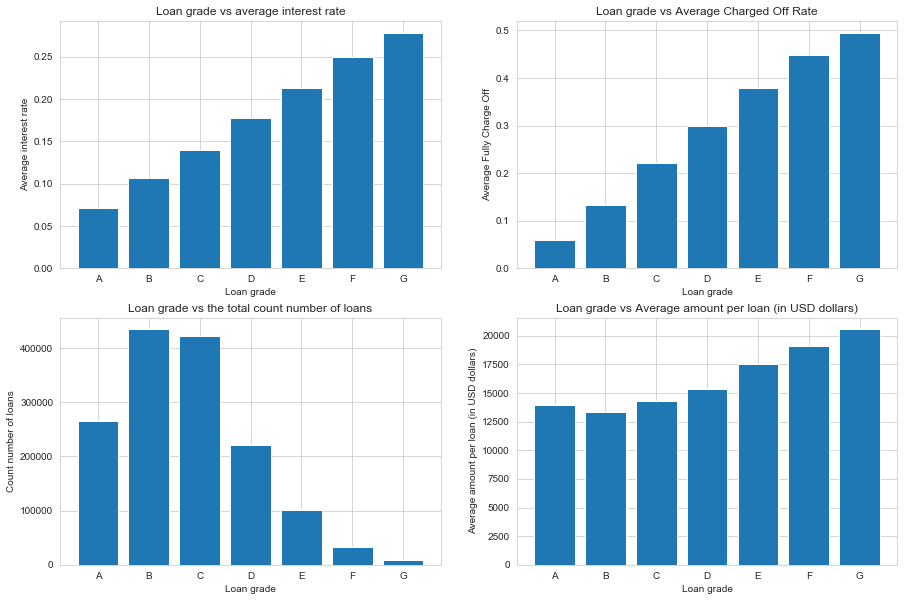

In [14]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.bar(loans_grade_mean.index, (loans_grade_mean['int_rate']*0.01), )
plt.title('Loan grade vs average interest rate')
plt.xlabel('Loan grade')
plt.ylabel('Average interest rate')

plt.subplot(2,2,2)
plt.bar(loans_grade_mean.index, (1-loans_grade_mean['loan_status']))
plt.title('Loan grade vs Average Charged Off Rate')
plt.xlabel('Loan grade')
plt.ylabel('Average Fully Charge Off')

plt.subplot(2,2,3)
plt.bar(loans_grade_count.index, loans_grade_count.values)
plt.title('Loan grade vs the total count number of loans')
plt.xlabel('Loan grade')
plt.ylabel('Count number of loans')

plt.subplot(2,2,4)
plt.bar(loans_grade_mean.index, loans_grade_mean['loan_amnt'])
plt.title('Loan grade vs Average amount per loan (in USD dollars)')
plt.xlabel('Loan grade')
plt.ylabel('Average amount per loan (in USD dollars)')

- From the first two plots, we can see as the loan grade goes from A to G, interest rate increases, while Charged Off Rate also goes up. This is not surprise because higher risk compensate with higher interest rate.
- The third plot tells us the majority of loans are in grade B and C, followed by A and then D, while the last plot says for the high risk loans E, F, G, as the loan is riskier, the average amount per loans is higher
- This implies there are small amount of borrowers who do not have good credit rating actually borrowed more money, 20000 USD in average for G loans. However, half of them are not likely to Fully Paid. Those are high risk loans, as a conservative investor, it is suggested to avoid those loans.

**As we care most about the risk of the loan, print out the exact number of Charged Off rate and interest rate for each loan grade**

In [16]:
loans_grade_charged_off = 1-loans_paid_or_default.groupby('grade')['loan_status'].mean()
loans_grade_interest = (loans_paid_or_default.groupby('grade')['int_rate'].mean())*0.01
loans_grade_charged_off = pd.DataFrame(loans_grade_charged_off)

loans_grade_charged_off.rename({'loan_status':'charged_off_rate'}, axis=1, inplace=True)
loans_grade_interest = pd.DataFrame(loans_grade_interest)
loans_grade_interest.rename({'int_rate':'interest_rate'}, axis=1, inplace=True)

investment = loans_grade_charged_off.join(loans_grade_interest) 
print(investment)

       charged_off_rate  interest_rate
grade                                 
A              0.059498       0.071004
B              0.132787       0.106659
C              0.221431       0.140364
D              0.298512       0.178099
E              0.378664       0.212713
F              0.447809       0.250325
G              0.494779       0.278173


In [17]:
investment.to_csv('investment.csv', index=False)

The Charged Off Rate is very high, especially for E, F, G. 

Loans with A grade has about 0.059 of Charged Off rate. This means if an investor only choose A loan to invest, there could be '0.059' of the chance that they will lose money. 

**Note:** 

1. This charged off rate and interest rate is the average for each grade based on statistic data. When an investor make investment decision, they will know the specific interest rate for each loan, but of course not charged off rate. And this is something we will trying to predict with our machine learning model.

2. When a loan is charged off, it does NOT mean that the investor will lose all of their investment; The loan payment schedule is similar like a mortage (the bank gives you a loan for your house and you pay back principle and interest together every month for the same amount of money over the whole morgage term. You may Pre-pay when you start earn more money and you may also unable to pay continiously if you lose your job and then you are 'charged off', but the bank still get some money back). This can explain why the charged off rate is so high and even higher than interest rate. This makes it more difficult to calculate how much lost an investor could have based on average charged off rate. However, for a more conservative investor, one thing for sure is we want the charged off rate as low as possible even though it means we may miss some good investment oppotunity. Understanding this is important for this project, because this will determine which metric should be used in machine learning model. In this project, we want to make a machine leanrning model that make sure investors still make money if some of the loans are charged-off and investor lost all the principal and interests.

**1.6 Visualize the year trend for peer to peer loans.**

1. For the number of loans and the average amounts per loan (USD dolloars), I did not include 2007 and 2019 is because these two years only have half year data.

2. For charged off rate and interest rate I only include data from 2007 to 2016, because for the loans from 2017 to 2019, most of them are 'current', i.e. the loans have not expired, so calculating average charged off rate in those years are biased.

In [18]:
# create a column for loan issue year
loans_2007_2019['issue_year'] = pd.DatetimeIndex(loans_2007_2019['issue_d']).year

# Filter the data not include 2007 and 2019
loans_2008_2018 = loans_2007_2019[(loans_2007_2019['issue_year']!=2007)&
                                  (loans_2007_2019['issue_year']!=2019)]

# calculate the total number of loans issued for each year, # each row is one loan
loans_year_count = loans_2008_2018.groupby('issue_year')['loan_amnt'].count() 

# calculate the average amounts of loans (USD dolloars) from 2008 to 2018, each loan has different amount
loans_year_average = loans_2008_2018.groupby('issue_year')['loan_amnt'].mean()

# calculate the avegrage of 'Fully paid rate' from 2007 to 2016

loans_paid_or_default['issue_year'] = pd.DatetimeIndex(loans_paid_or_default['issue_d']).year
loans_2007_2016 = loans_paid_or_default[(loans_paid_or_default['issue_year']!=2017)&
                                                      (loans_paid_or_default['issue_year']!=2018)&
                                                      (loans_paid_or_default['issue_year']!=2019)]

loans_2007_2016_loan_status = loans_2007_2016.groupby('issue_year')['loan_status'].mean()

loans_2007_2016_interest = loans_2007_2016.groupby('issue_year')['int_rate'].mean()

Text(0, 0.5, 'Average Interest Rate (%)')

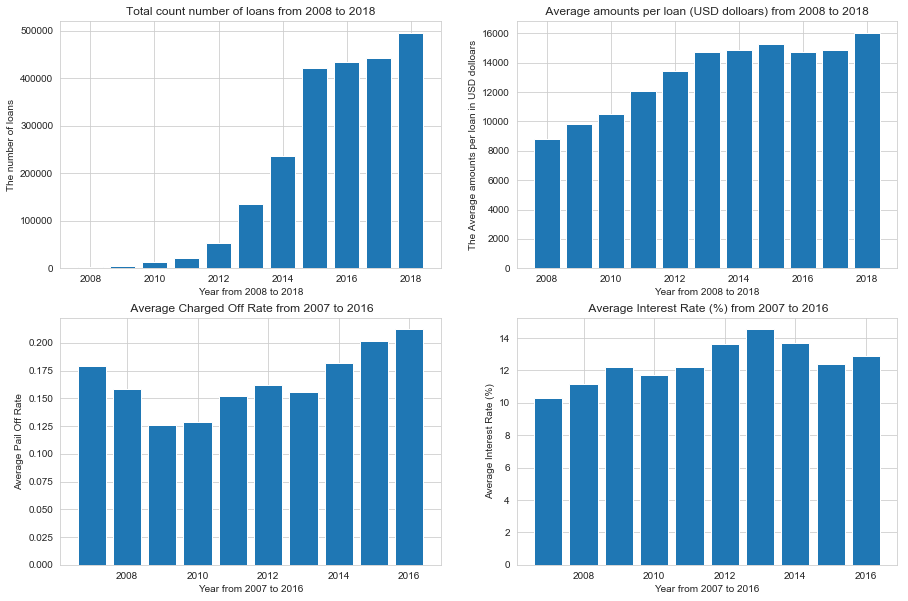

In [19]:
plt.figure(figsize = (15,10))

# Visualize the total number of loans from 2008 to 2018
plt.subplot(2,2,1)
plt.bar(loans_year_count.index, loans_year_count.values)
plt.title('Total count number of loans from 2008 to 2018')
plt.xlabel('Year from 2008 to 2018')
plt.ylabel('The number of loans')

# Visualize the average amounts of per loan (USD dolloars) from 2008 to 2018 
plt.subplot(2,2,2)
plt.bar(loans_year_average.index, loans_year_average.values)
plt.title(' Average amounts per loan (USD dolloars) from 2008 to 2018 ')
plt.xlabel('Year from 2008 to 2018')
plt.ylabel('The Average amounts per loan in USD dolloars')

plt.subplot(2,2,3)
plt.bar(loans_2007_2016_loan_status.index, (1-loans_2007_2016_loan_status.values))
plt.title(' Average Charged Off Rate from 2007 to 2016')
plt.xlabel('Year from 2007 to 2016')
plt.ylabel('Average Pail Off Rate')

plt.subplot(2,2,4)
plt.bar(loans_2007_2016_interest.index, loans_2007_2016_interest.values)
plt.title(' Average Interest Rate (%) from 2007 to 2016')
plt.xlabel('Year from 2007 to 2016')
plt.ylabel('Average Interest Rate (%)')

- From the first two chart, we can clearly see from 2008 to 2018, the number of loans issued increased sharply. After 2015, it continued to increase, but growth is more slowly. However 2018 has good growth compared with 2017. The average amount of per loan also increased from 2008 to 2018. This again proved the growth in popularity of Peer to Peer lending in the last decade. According to PwC, U.S. peer-to-peer lending platforms’ origination volumes have grown an average of 84% per quarter since 2007. Read more [here](https://www.pwc.com/us/en/industries/banking-capital-markets/consumer-finance/library.html)
- The last two charts show the charged off rate decreased a little bit from 2007 to 2009, and since then it keeps going up, this means the risk of investment is becoming higher. Interest rate increased unitl 2013 and then went down.

Now we have done some analyzing and plotting, we can start to clean our data to prepare for machine learning. 

**Take 20% of the data and save it as Test Data - The first train test split**

Note that this is not the same train test split we do to test our model. The other 80% of the data will be split again in Part 2 to test the model and select the best one. The *test data* we have from this stage will be saved to a new file as raw new data to test if our model is applicable for new data. This is to mimic the real world situation to prevent the case that we build a model, but can not applied to new data. The data cleaning process I will do in next part will only clean the 80% of *Training data*. Then I will write a script about all the cleaning and pre-processing step into a function, and use this function to process new data in order to fit the model. 

**Before changing our data, filter the data and save a file for 2019 current loan data for future use**

These are the loans that we don't know whether it will be fully paid back. This can be used as new data to test our model in the future

In [21]:
# The filter the data again to only select the data in 2019.
loans_2019_current = loans_2007_2019[(loans_2007_2019['loan_status']=='Current')
                                     |(loans_2007_2019['loan_status']=='Issued')
                                     &(loans_2007_2019['issue_year']==2019)]

print('The number of rows and columns is: ', loans_2019_current.shape)

# save this file
loans_2019_current.to_csv('loans_2019_current.csv', index=False)

The number of rows and columns is:  (980902, 145)


**Filter the data with `loan_status` as 'Fully Paid' and 'Charged Off' for building machine learning model**

We only need the loans either 'Fully Paid' or 'Charged Off', and our model will be a binary classification.

In [22]:
# Remove all rows that contain have loan status other than Fully Paid or Charged Off 
loans_2007_2019_paid_or_default = loans_2007_2019.loc[loans_2007_2019['loan_status'].isin(['Fully Paid', 'Charged Off'])]

print('The number of rows and columns is: ', loans_2007_2019_paid_or_default.shape)

The number of rows and columns is:  (1485524, 145)


**Convert target column `loan_status` to 0 and 1**

In [23]:
status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}

loans_2007_2019_paid_or_default = loans_2007_2019_paid_or_default.replace(status_replace)

In [24]:
features = loans_2007_2019_paid_or_default.drop('loan_status', axis=1)

target = loans_2007_2019_paid_or_default['loan_status']

**Take 20% of the data as Test Data**

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

**Save test data**

In [26]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

**Join X_train and y_train together, since they have the same index and rename as 'loans_2007_2019'**

This is to make sure during the cleaning process, the X_train and y_train are in the same index and same length. 

In [27]:
X_train.shape, y_train.shape

((1188419, 144), (1188419,))

In [28]:
X_train.head(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_year
118451,NaN,NaN,16000.0,16000.0,16000.0,36 months,11.14%,524.89,B,B2,American Association for Clinical Chemis,8 years,RENT,65000.0,Not Verified,Mar-2013,n,NaN,Borrower added on 02/22/13 > I had a previous loan at Lending Club and paid it off. Now I want to consolidate a few remaining credit cards. I'm almost debt free now!<br>,credit_card,Ditch the rest of the credit cards,223xx,VA,15.76,0.0,May-2000,1.0,NaN,NaN,9.0,0.0,13484.0,37.6%,14.0,f,0.0,0.0,18847.83,18847.83,16000.0,2847.83,0.0,0.0,0.0,Nov-2015,2576.24,NaN,Nov-2015,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,39639.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35900.0,NaN,NaN,NaN,3.0,4404.0,20256.0,38.1,0.0,0.0,130.0,155.0,7.0,3.0,0.0,7.0,NaN,3.0,NaN,0.0,3.0,4.0,5.0,6.0,5.0,6.0,8.0,4.0,9.0,0.0,0.0,0.0,2.0,100.0,20.0,0.0,0.0,63549.0,39639.0,32700.0,25728.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2013.0


In [29]:
y_train = pd.DataFrame(y_train)

In [30]:
y_train.head()

,loan_status
118451,1
19723,1
188169,1
135602,0
135250,1


In [31]:
# combine them together 
loans_2007_2019 = pd.concat([X_train, y_train], axis=1)

In [32]:
loans_2007_2019.shape

(1188419, 145)

<a id='clean'></a>
## 2. Inital Data Cleaning 

**2.1. Check missing value for each columns and remove the columns that have more than 30% of missing value**

Since every borrower is different, if we fill all the missing data with our guess, no matter it's medium or other value, this won't give us good information, so we choose drop those.

In [33]:
# check the percentage of misssing values in each columns
missing_fraction = loans_2007_2019.isnull().mean().sort_values(ascending=False)

print('The percentage of misssing values in each columns is: ', missing_fraction)

The percentage of misssing values in each columns is:  id                                            1.000000e+00
next_pymnt_d                                  1.000000e+00
url                                           1.000000e+00
member_id                                     1.000000e+00
orig_projected_additional_accrued_interest    9.967629e-01
hardship_end_date                             9.952273e-01
payment_plan_start_date                       9.952273e-01
hardship_length                               9.952273e-01
hardship_dpd                                  9.952273e-01
hardship_loan_status                          9.952273e-01
hardship_last_payment_amount                  9.952273e-01
hardship_payoff_balance_amount                9.952273e-01
hardship_amount                               9.952273e-01
deferral_term                                 9.952273e-01
hardship_status                               9.952273e-01
hardship_reason                               9.952273e-01
h

There are many ways we can deal with missing value:
1. Remove the columns that contain a certain amount of missing value; In our case, we remove the columns that have more than 30% of missing values, this is based on the above percentage of missing values for each columns and the column meaning, if the column is absolutely a very important features that could impact whether the loan will be paid off or not, then we should not remove it.
2. Remove the rows with missing values, but this will remove other useful information too.  
3. Fill in missing values with the best estimated value based on the distribution of the data.

For our purpose, we will first drop columns with more than 30% of missing value, then drop rows which every value is missing (i.e. there is no any information about this loan), then we will do more data cleaning for each column and will drop some along the process; lastly, we will either remove or fill in the remaining missing values.

In [34]:
# sort the columns that have more than 30% of missing value
drop_list = sorted(list(missing_fraction[missing_fraction>0.3].index))

# see how many columns we will drop
print('The number of the columns with more than 30% of missing values is: ', len(drop_list))

The number of the columns with more than 30% of missing values is:  58


In [35]:
# drop these columns 
loans_2007_2019 = loans_2007_2019.drop(drop_list, axis=1)

In [36]:
# check the result
print('The number of rows and columns left is: ',loans_2007_2019.shape)

The number of rows and columns left is:  (1188419, 87)


We still have some columns with missing value, we will clean later.

**2.2 Drop the rows where all the values are NaN.**

In [37]:
# drop the rows that are all NaNs 
loans_2007_2019.dropna(axis = 0, how = 'all', inplace=True)

# check the result
print('The number of rows and columns left is: ', loans_2007_2019.shape)

The number of rows and columns left is:  (1188419, 87)


**2.3 Remove duplicated data**

In [38]:
# check if any rows are duplicated
print('The number of duplicated rows is: ', loans_2007_2019.duplicated().sum())

The number of duplicated rows is:  0


**2.4 Drop columns that leak information from the future, i.e. the information that will only be available after the loan has already been funded**

Those are the information that an investor and Lendng Club will not know before they list the loan. These are not usefull for our analysis, and in machine learning modelling process, it can cause our model to overfit. This is because the model would be using data about the target column that wouldn't be available when we're using the model on future loans. This requires deep understanding of what each column means.

Referring to the data dictionary, the following are the columns that leak data for future information, these information isn't available to an investor before the loan is fully funded and we don't want to include it in our model: The following are the columns that leak future imformations and need to be removed. 
- `funded_amnt`: The total amount committed to that loan at that point in time; 
- `funded_amnt_inv`: The total amount committed by investors for that loan at that point in time.
- `out_prncp`: Remaining outstanding principal for total amount funded; 
- `out_prncp_inv`: Remaining outstanding principal for portion of total amount funded by investors; 
- `total_pymnt`: Payments received to date for total amount funded; 
- `total_pymnt_inv`: Payments received to date for portion of total amount funded by investors; 
- `total_rec_prncp`: 	Principal received to date;
- `total_rec_int`: Interest received to date;
- `total_rec_late_fee`: Late fees received to date; 
- `recoveries`: post charge off gross recovery; 
- `collection_recovery_fee`: 	post charge off collection fee;
- `last_pymnt_d`: Last month payment was received; 
- `last_pymnt_amnt`: Last total payment amount received;
- `tot_coll_amt`: Total collection amounts ever owed

In [39]:
# those are the columns we have identified to drop:
remove_col = ['funded_amnt','funded_amnt_inv','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
             'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
             'last_pymnt_amnt','tot_coll_amt']

# drop those columns
loans_2007_2019 = loans_2007_2019.drop(remove_col,axis=1)

# check the result
print('The number of rows and columns left is: ', loans_2007_2019.shape)

The number of rows and columns left is:  (1188419, 73)


**2.5 Remove the columns that are not useful for machine learning model**

First, drop the columns that contains only one unique value except NaN, those are for sure not usefull for machine leaning.

Some columns may contain two unique vaules, and one is NaN; So we need to check how many unique values the column has if removing NaN. Thoes columns have the same value for every loans, this is not useful for analysis and machines learning, we will need to remove them.

In [40]:
# get all the columns we want to exam
orig_columns = loans_2007_2019.columns

# create an empty list for the columns we want to drop
drop_columns = []

# write a for loop
for col in orig_columns:
    col_series = loans_2007_2019[col].dropna().unique()
    if len(col_series) == 1:
        # those columns only contain one unique value
        drop_columns.append(col)
        
# drop the columns
loans_2007_2019 = loans_2007_2019.drop(drop_columns, axis=1)

# show what we dropped
print('The columns that have only one unique value if removing NaN are: ', drop_columns)

print('\n')
# check the result
print('The number of rows and columns left is: ',loans_2007_2019.shape)

The columns that have only one unique value if removing NaN are:  ['policy_code']


The number of rows and columns left is:  (1188419, 72)


**Remove the columns with more than 90% the same value.**

This step is not nessesary, however, in general columns with very little variabilty are not useful for machine learning model, it's almost like all the values are the same. **I have also tested the same model without removing those columns, and it didn't return better results.**

The reason I decided to remove those columns in this step is, if those columns have missing value while other columns don't have, and later when I remove rows with missing value, I will remove the rows I should not remove. So it is the best to remove all the columns not usefull ofr machine learning first.

In [41]:
# get all the columns we want to exam
orig_columns = loans_2007_2019.columns

# create an empty list for the columns we want to drop
drop_columns = []

# write a for loop
for col in orig_columns:
    
    # select the columns that offers very little variability
    if loans_2007_2019[col].value_counts(normalize=True, dropna=False).values[0]>0.9:

        # those columns won't have much predictive value. let's drop it.
        drop_columns.append(col)

# drop the columns
loans_2007_2019 = loans_2007_2019.drop(drop_columns, axis=1)

# show what we dropped
print('The columns that offers very little variability and need to be removed are: ', drop_columns)

print('\n')
# check the result
print('The number of rows and columns in 2007 to 2019 model data is: ',loans_2007_2019.shape)

The columns that offers very little variability and need to be removed are:  ['pymnt_plan', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


The number of rows and columns in 2007 to 2019 model data is:  (1188419, 60)


**Remove `issue_year`**

We create this column for analysis, we don't need this in machine leaning model

In [42]:
loans_2007_2019.drop('issue_year', axis=1, inplace=True)
# check the result
print('The number of rows and columns in 2007 to 2019 model data is: ',loans_2007_2019.shape)

The number of rows and columns in 2007 to 2019 model data is:  (1188419, 59)


**2.6 Drop columns that have redundant information**

- `zip_code`: redundant with the `addr_state` column, also since only the first 3 digits of the 5 digit zip code are visible, which only can be used to identify the state the borrower lives in, this column is not useful for us. 
- `sub_grade`: redundant with the `grade` and `int_rate` column. From data dictionary, we know that each grade has 5 subgrade.

In [43]:
# drop columns  'zip_code' and 'sub_grade'
loans_2007_2019 = loans_2007_2019.drop(['zip_code', 'sub_grade'],axis=1)

# check the result
print('The number of rows and columns left is: ', loans_2007_2019.shape)

The number of rows and columns left is:  (1188419, 57)


We are now able to reduce the column number to 58, so far we started to become familiar with the columns in the dataset and removed many columns that aren't useful for analyzing and modeling. Our data is still not clean and many missing values

<a id='category'></a>
## 3. More Data Cleaning on Category columns

**Select the columns that are object**

In [44]:
# select all the columns that are object
object_col_df = loans_2007_2019.select_dtypes(include=['object'])
# view the first row
object_col_df.head(1)

,term,int_rate,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,purpose,title,addr_state,earliest_cr_line,revol_util,initial_list_status,last_credit_pull_d
118451,36 months,11.14%,B,American Association for Clinical Chemis,8 years,RENT,Not Verified,Mar-2013,credit_card,Ditch the rest of the credit cards,VA,May-2000,37.6%,f,Nov-2015


From the sample data, we can see many values are not in the right form, some should be numerical value, some shows repeated information or lengthy text. 

**3.1. Investigate date columns**

- `earliest_cr_line`: The month the borrower's earliest reported credit line was opened; we do not need ths column for our analysis
- `last_credit_pull_d`: The most recent month LendingClub pulled credit for this loan; we do not need ths column for our analysis.
- `issue_d`: The date which the loan was funded. It means the date investor received full amount of money they need. We don't need this column; also it leak future information.

In [45]:
# drop columns `earliest_cr_line`
loans_2007_2019.drop(['earliest_cr_line', 'last_credit_pull_d','issue_d'], axis=1, inplace=True)

**3.2. `purpose` and `title` looks similar, delete one of them**

Based on the first row's values for `purpose` and `title`, it seems like these columns could reflect the same information. Let's explore the unique value counts separately to confirm if this is true.

- `purpose`: a category provided by the borrower for the loan request,
- `title`: loan title provided the borrower

In [46]:
# view what values in 'purpose' column
loans_2007_2019['purpose'].value_counts(dropna=False)

debt_consolidation    686540
credit_card           261088
home_improvement       78000
other                  70098
major_purchase         26268
medical                13901
small_business         13465
car                    12913
moving                  8408
vacation                8212
house                   6633
wedding                 1840
renewable_energy         805
educational              248
Name: purpose, dtype: int64

In [47]:
# check the number of unique value in the 'title' column
print('The number of unique value is: ', loans_2007_2019['title'].nunique())

print('\n')

# there are many values; show first 10 items in this clomun
print(loans_2007_2019['title'].value_counts(dropna=False).head(10))

The number of unique value is:  50903


Debt consolidation         589752
Credit card refinancing    224240
Home improvement            67862
Other                       61158
Major purchase              21973
NaN                         15573
Debt Consolidation          12533
Medical expenses            12295
Business                    10512
Car financing               10205
Name: title, dtype: int64


It seems like the `purpose` and `title` columns do contain overlapping information but we'll keep the `purpose` column since it contains a few discrete values. In addition, the `title` column has data quality issues since many of the values are repeated with slight modifications (e.g. Debt Consolidation and Debt Consolidation Loan and debt consolidation).

In [48]:
# drop 'title' column
loans_2007_2019 = loans_2007_2019.drop('title', axis=1)

**3.3 Remove % in `int_rate` and `revol_util`**

Those columns that actually represent numeric values, that need to be converted:

`int_rate`: interest rate of the loan in %

`revol_util`: revolving line utilization rate or the amount of credit the borrower is using relative to all available credit, read more [here](https://blog.credit.com/2013/04/what-is-revolving-utilization-65530/).

In [49]:
# Remove % in int_rate and change the data type to float
loans_2007_2019['int_rate'] = loans_2007_2019['int_rate'].str.rstrip('%').astype('float')

# Remove % in revol_util and change the data type to float
loans_2007_2019['revol_util'] = loans_2007_2019['revol_util'].str.rstrip('%').astype('float')

**3.4 Change values in `emp_length`**

In [50]:
# see what are the values in 'emp_length' column
loans_2007_2019['emp_length'].value_counts(dropna=False)

10+ years    390956
2 years      107548
< 1 year      95735
3 years       95163
1 year        78292
5 years       74199
4 years       71435
NaN           71085
6 years       55049
8 years       52857
7 years       51523
9 years       44577
Name: emp_length, dtype: int64

I erred on the side of being conservative with the 10+ years, < 1 year mappings. I assume that people who may have been working more than 10 years have only really worked for 10 years, also assume that people who've worked less than a year or if the information is not available that they've worked for 0. 

In [51]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0
    }
}

loans_2007_2019 = loans_2007_2019.replace(mapping_dict)

In [52]:
# view the result
loans_2007_2019['emp_length'].value_counts(dropna=False)

 10.0    390956
 2.0     107548
 0.0      95735
 3.0      95163
 1.0      78292
 5.0      74199
 4.0      71435
NaN       71085
 6.0      55049
 8.0      52857
 7.0      51523
 9.0      44577
Name: emp_length, dtype: int64

**3.5 Check `emp_title` column**

`emp_title`: The job title supplied by the Borrower when applying for the loan.

In [53]:
# check the number of unique value in the 'emp_title' column
print('The number of unique value is: ', loans_2007_2019['emp_title'].nunique())

print('\n')
# show first 10 items in this clomun
print(loans_2007_2019['emp_title'].value_counts(dropna=False).head(10))

The number of unique value is:  335861


NaN                 77733
Teacher             19088
Manager             17383
Owner                9470
Registered Nurse     7954
RN                   7694
Supervisor           7373
Driver               6993
Sales                6752
Project Manager      5672
Name: emp_title, dtype: int64


We can see there are 335861 categories in this column and the the most frequent one is NaN, we can drop this column. 

In [54]:
# drop 'emp_title' 
loans_2007_2019 = loans_2007_2019.drop('emp_title', axis=1)

**3.6 Check again what is left in our category columns**

In [55]:
# select all the columns that are object
object_col_df = loans_2007_2019.select_dtypes(include=['object'])
# view the first row
object_col_df.head(1)

,term,grade,home_ownership,verification_status,purpose,addr_state,initial_list_status
118451,36 months,B,RENT,Not Verified,credit_card,VA,f


In [56]:
# check what are the percentage of each value in those columns using a for loop: 
for col in object_col_df.columns:
    print(loans_2007_2019[col].value_counts(normalize=True, dropna=False))

 36 months    0.756839
 60 months    0.243161
Name: term, dtype: float64
B    0.292385
C    0.283943
A    0.178205
D    0.148446
E    0.067753
F    0.022760
G    0.006508
Name: grade, dtype: float64
MORTGAGE    0.494533
RENT        0.396344
OWN         0.108679
ANY         0.000312
OTHER       0.000098
NONE        0.000034
Name: home_ownership, dtype: float64
Source Verified    0.390512
Verified           0.304997
Not Verified       0.304491
Name: verification_status, dtype: float64
debt_consolidation    0.577692
credit_card           0.219694
home_improvement      0.065633
other                 0.058984
major_purchase        0.022103
medical               0.011697
small_business        0.011330
car                   0.010866
moving                0.007075
vacation              0.006910
house                 0.005581
wedding               0.001548
renewable_energy      0.000677
educational           0.000209
Name: purpose, dtype: float64
CA    0.144585
TX    0.081952
NY    0.081660
FL 

Now our data is mostly cleaned except for missing value. Before we clean our data, it is a good idea to save our data in this stage. In this way, we can test whether different ways of handlling missing data can affect our machine learing performance.

In [57]:
loans_2007_2019.to_csv('loans_2007_2019_with_NaN.csv', index=False)

**Visualize on selected columns**

Text(0, 0.5, 'The number of loans for each category')

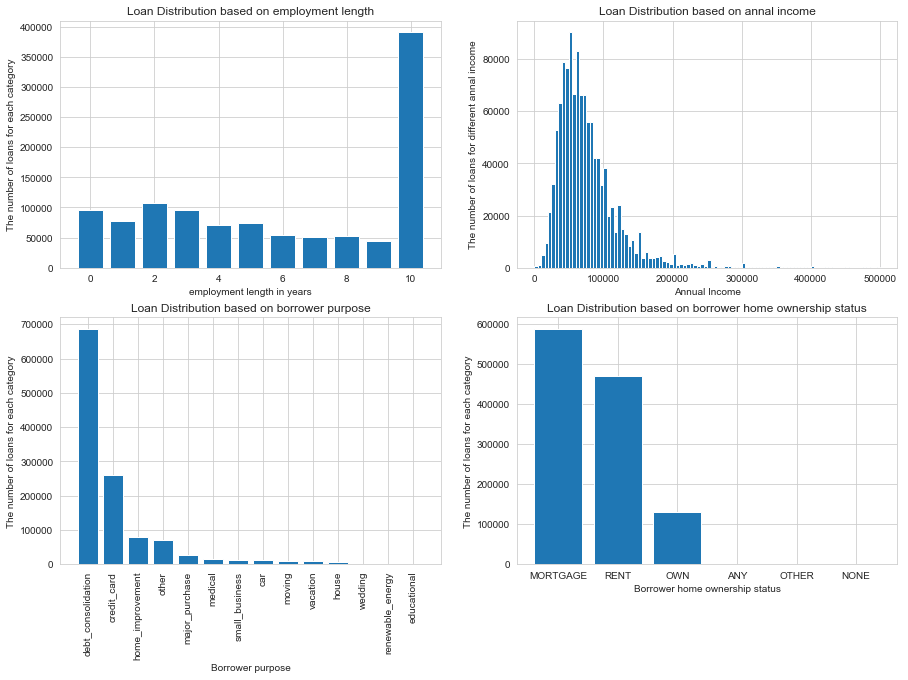

In [58]:
plt.figure(figsize=(15,10))

# code for plotting bar chart for employment length:
plt.subplot(2,2,1)
plt.bar(loans_2007_2019['emp_length'].value_counts().index, loans_2007_2019['emp_length'].value_counts().values)
plt.title('Loan Distribution based on employment length')
plt.xlabel('employment length in years')
plt.ylabel('The number of loans for each category')

# code for plotting histagram for annal income:
plt.subplot(2,2,2) # noted that there are some extremely high income can make our plot high screwed, that is why I set a range
plt.hist(loans_2007_2019['annual_inc'], bins=100, range=(0, 500000)) 
plt.title('Loan Distribution based on annal income')
plt.xlabel('Annual Income')
plt.ylabel('The number of loans for different annal income')

# code for plotting bar chart for purpose:
plt.subplot(2,2,3)
plt.bar(loans_2007_2019['purpose'].value_counts().index, loans_2007_2019['purpose'].value_counts().values)
plt.title('Loan Distribution based on borrower purpose')
plt.xlabel('Borrower purpose')
plt.xticks(rotation=90)
plt.ylabel('The number of loans for each category')

# code for plotting bar chart 
plt.subplot(2,2,4)
plt.bar(loans_2007_2019['home_ownership'].value_counts().index, loans_2007_2019['home_ownership'].value_counts().values)
plt.title('Loan Distribution based on borrower home ownership status')
plt.xlabel('Borrower home ownership status')
plt.ylabel('The number of loans for each category')

<a id='missing'></a>
## 4. Handling missing values

So we already removed the columns with missing values of more than 30%, and this reduced our column number. After further cleaning, we still have some columns with less than 10% of missing value. 

**4.1 list the columns and the percentage of missing values**

In [59]:
# check the percentage of misssing values and sort the data
missing_fraction = loans_2007_2019.isnull().mean().sort_values(ascending=False)
print('The column name and the percentage of missing values is: ')
print('\n')
print(missing_fraction[missing_fraction>0])

The column name and the percentage of missing values is: 


mths_since_recent_inq         1.274912e-01
mo_sin_old_il_acct            7.409676e-02
emp_length                    5.981476e-02
pct_tl_nvr_dlq                4.562953e-02
avg_cur_bal                   4.553949e-02
num_rev_accts                 4.552098e-02
num_bc_tl                     4.552014e-02
num_il_tl                     4.552014e-02
num_accts_ever_120_pd         4.552014e-02
num_actv_bc_tl                4.552014e-02
num_actv_rev_tl               4.552014e-02
mo_sin_old_rev_tl_op          4.552014e-02
num_rev_tl_bal_gt_0           4.552014e-02
num_op_rev_tl                 4.552014e-02
mo_sin_rcnt_tl                4.552014e-02
num_tl_op_past_12m            4.552014e-02
total_il_high_credit_limit    4.552014e-02
total_rev_hi_lim              4.552014e-02
tot_hi_cred_lim               4.552014e-02
tot_cur_bal                   4.552014e-02
mo_sin_rcnt_rev_tl_op         4.552014e-02
bc_util                       4.29604

`mths_since_recent_inq` : Months since most recent inquiry. It has the highest percentage of the missing value, let's plot the data to see its distribution, from data dictionary, it means .

In [60]:
# check statistical information for this column
loans_2007_2019['mths_since_recent_inq'].describe()

count    1.036906e+06
mean     6.745950e+00
std      5.862184e+00
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      2.500000e+01
Name: mths_since_recent_inq, dtype: float64

Text(0, 0.5, 'The number of loans')

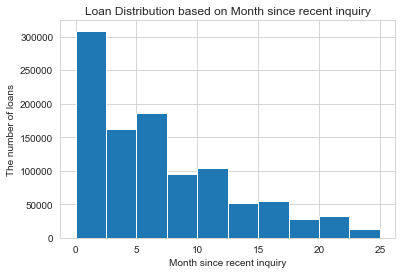

In [61]:
plt.hist(loans_2007_2019['mths_since_recent_inq']) 
plt.title('Loan Distribution based on Month since recent inquiry')
plt.xlabel('Month since recent inquiry')
plt.ylabel('The number of loans')

It looks like it's reasonable to fill NaN as median in this column, which is 6

**4.2 Fill NaN with median value for `mths_since_recent_inq` column**

In [62]:
loans_2007_2019['mths_since_recent_inq'].fillna(loans_2007_2019['mths_since_recent_inq'].median(), inplace=True)

**4.3 Drop all the rows with missing values**

Since there are many columns that still contain missing value, the highest percentage is 0.06768, this is not very high, since we already have a lot of data, we can remove rows with missing value. **I have also tested to fill missing data with median value for all the columns and use it for the same machine learning model, and there isn't too much difference.** In this case choosing the simpler way is better.

In [63]:
loans_2007_2019 = loans_2007_2019.dropna(axis=0)

Check which columns still have missing values:

In [64]:
# double check if we have any missing values left. 
print('Is there any cloumns that contain missing value: ', loans_2007_2019.isna().sum().any())
print('The number of rows and columns left is: ', loans_2007_2019.shape)

Is there any cloumns that contain missing value:  False
The number of rows and columns left is:  (1023834, 52)


Now we have done our data cleaning after a long process.

Noted that to this step, we only covered the basic cleaning. For machine learning, we need to do more cleaning and change all the category data to binary form.

**Save a copy for Part 2**

In [65]:
# write out the data and save it to a new file
loans_2007_2019.to_csv('loans_2007_2019_cleaned.csv', index=False)

<a id='summary'></a>
## 5. Summary

In Part 1, we explored and analyzed our data, some of the key findings and indications are:
- **The Charged Off rate for all the loans in average is 19.57%**. This means if we choose loans to invest randomly, we could have about 19% of Charged-Off rate. *We should build a model to select loans that are predicted as "Fully_paid" with less that 19% of mistake, i.e. false positive rate is less than 19%*. 

- Loans with **A** grade has about **5.9%** of Charged Off rate. This means if an investor only choose A loans to invest, there is still 5.9% of the chance that they will lose money. And at the same time, by investing only A loans will not guarantee good return because interest rate is low too. *We should make our model to be able to build an investment portforlio that gives higher return than if the investors only choose A loans randomly*.

- From 2008 to 2018, the number of loans and the average amount of per loan kept increasing. This shows the growth of popularitu for peer-to-peer lending. 

- For the year trend on the risk of loans, from 2009 to 2016, the average charged Off rate went up gradually. This is not good news, but hopefully my machine learning model can help investors reduce the risk.